In [80]:
pip install xlrd

In [375]:
#---------------------------------------------------------------------------------------------------------------
# Nom du projet     : Classification
# Nom du programme  : SDA_Projet_Classification                                                                         
# Description       : L’objectif est de prédire le parti gagnant des élections présidentielles de 2020 aux Etats
#                   : Unis à partir de données socio-démographiques                        
# Auteur            : Yaya KONE,Papa Moussa THIOUNE                                                                         
# Date de création  : Novembre 2022                       
#---------------------------------------------------------------------------------------------------------------

# Librairies utiles pour le data management
import pandas as pd 
import numpy as np
import datetime as dt           
import os, glob, re  
from sklearn.model_selection import train_test_split

# Librairies utiles pour la data visualisation
import matplotlib.pyplot as plt 
import seaborn as sns 

#---------------------------------------------------------------------------------------------------------------
# Partie 1 : Constitution des donnes
#---------------------------------------------------------------------------------------------------------------

# Importation des resultats
df_results_2020 = pd.read_csv('data/2020_US_County_Level_Presidential_Results.csv')
df_results_0816 = pd.read_csv('data/US_County_Level_Presidential_Results_08-16.csv')

# Creation de la variable target dans la base df_results_2020
df_results_2020['target'] = df_results_2020['diff'].apply(lambda x : 1 if x>0 else 0)

# lecture des fichiers xls et concatenation des donnees socio-demographiques
list_file_xls = glob.glob("data/*.xls")              # Liste des fichiers xls contenus dans le dossier data
df_socio = pd.read_excel(list_file_xls[0], header=4) # Lecture du 1er fichier de la liste 
df_socio = df_socio.set_index(df_socio.columns[0])   # On utilise la variable fips comme index
for i in range(1,len(list_file_xls)):
    if 'Population' in list_file_xls[i]:
        df = pd.read_excel(list_file_xls[i], header=2) 
    else: 
        df = pd.read_excel(list_file_xls[i], header=4) 
    df = df.set_index(df.columns[0])
    df_socio = pd.concat([df_socio, df], axis=1) 

# Creation de la base df_votes contenant les resultats de 2008 a 2016 et les donnees socio-demographiques
df_votes = df_results_0816.set_index(['fips_code'])
df_votes = df_votes.join(df_socio)

# Creation de la variable target dans la base df_votes
df_votes['target'] = (df_votes['gop_2016'] > df_votes['dem_2016']) * 1

# Affichage des bases de donnees df_votes
print(f"La base df_votes fait {df_votes.shape[0]} lignes et {df_votes.shape[1]} colonnes\n") # On affiche le nombre de lignes et de colonnes 
print(f"{df_votes.head()}\n")                                                                # On affiche les 5 premieres lignes 

La base df_votes fait 3112 lignes et 344 colonnes

                       county  total_2008  dem_2008  gop_2008  oth_2008  \
fips_code                                                                 
26041            Delta County       19064      9974      8763       327   
48295         Lipscomb County        1256       155      1093         8   
1127            Walker County       28652      7420     20722       510   
48389           Reeves County        3077      1606      1445        26   
56017      Hot Springs County        2546       619      1834        93   

           total_2012  dem_2012  gop_2012  oth_2012  total_2016  ...  \
fips_code                                                        ...   
26041           18043      8330      9533       180       18467  ...   
48295            1168       119      1044         5        1322  ...   
1127            28497      6551     21633       313       29243  ...   
48389            2867      1649      1185        33        3184

Les informations sur la base df_votes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3112 entries, 0 to 3111
Data columns (total 51 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   county                                                                    3112 non-null   object 
 1   dem_2008                                                                  3112 non-null   int64  
 2   gop_2008                                                                  3112 non-null   int64  
 3   oth_2008                                                                  3112 non-null   int64  
 4   dem_2012                                                                  3112 non-null   int64  
 5   gop_2012                                                                  3112 non-null   int64  
 6   oth_2012                  

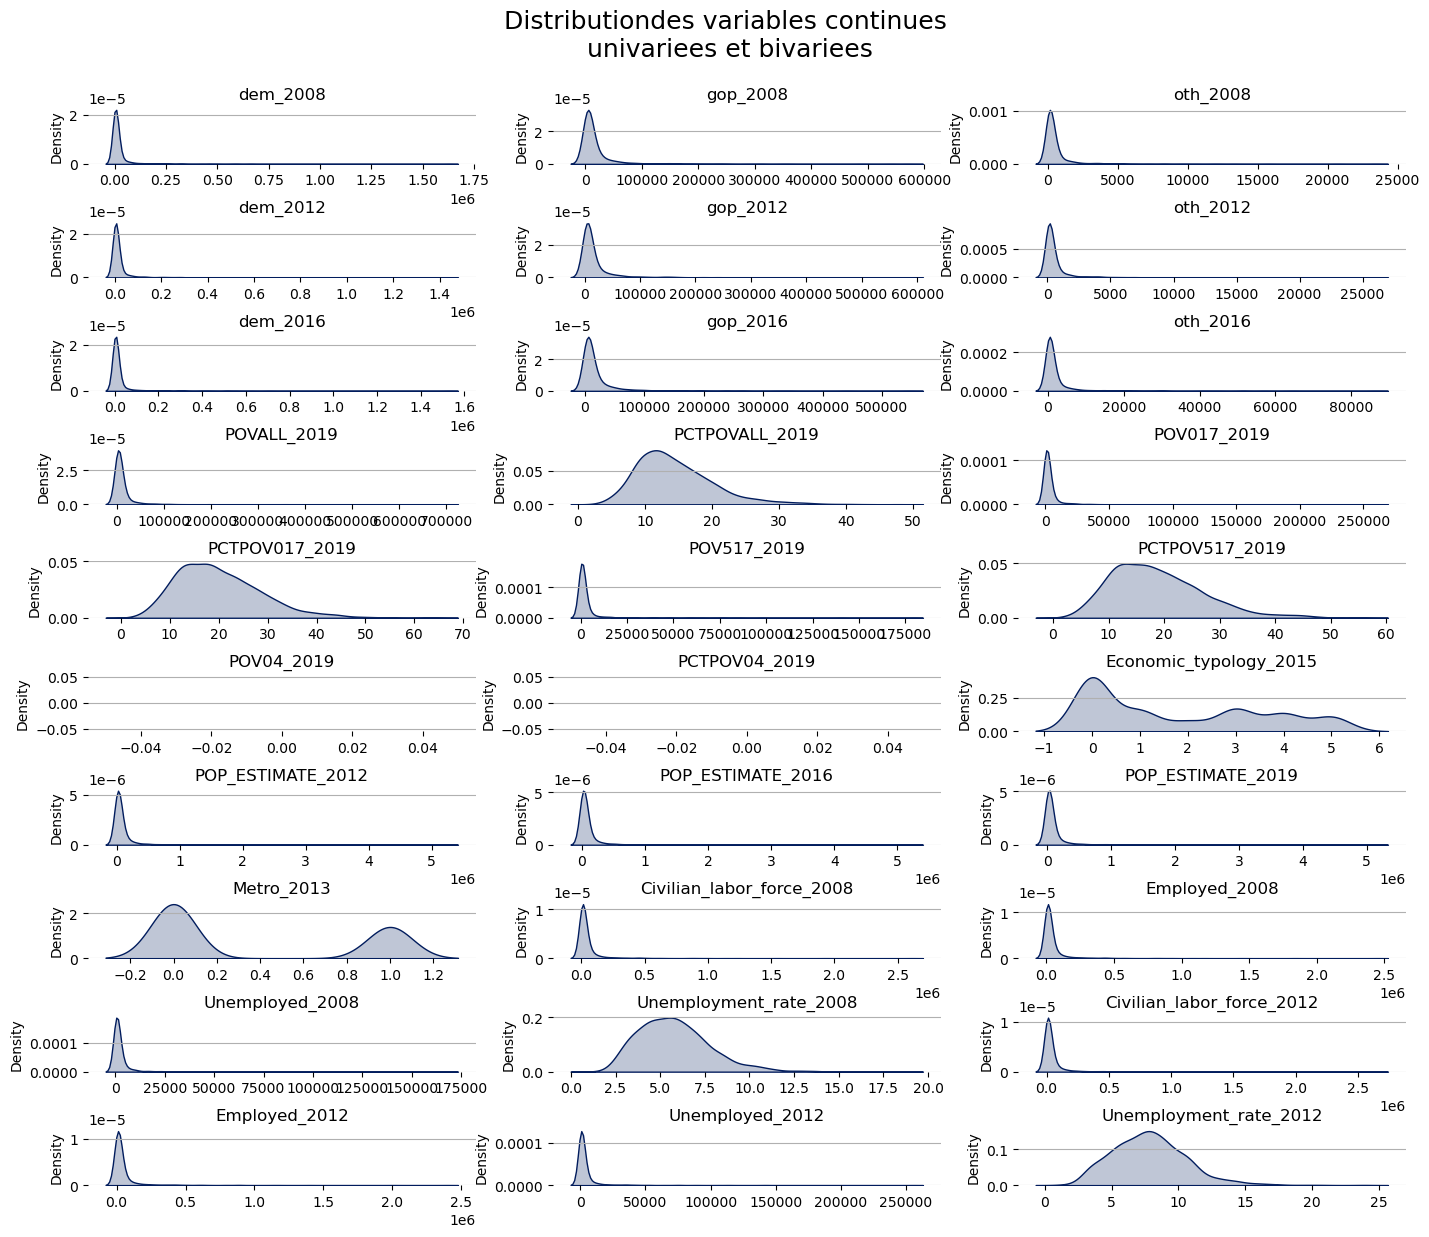

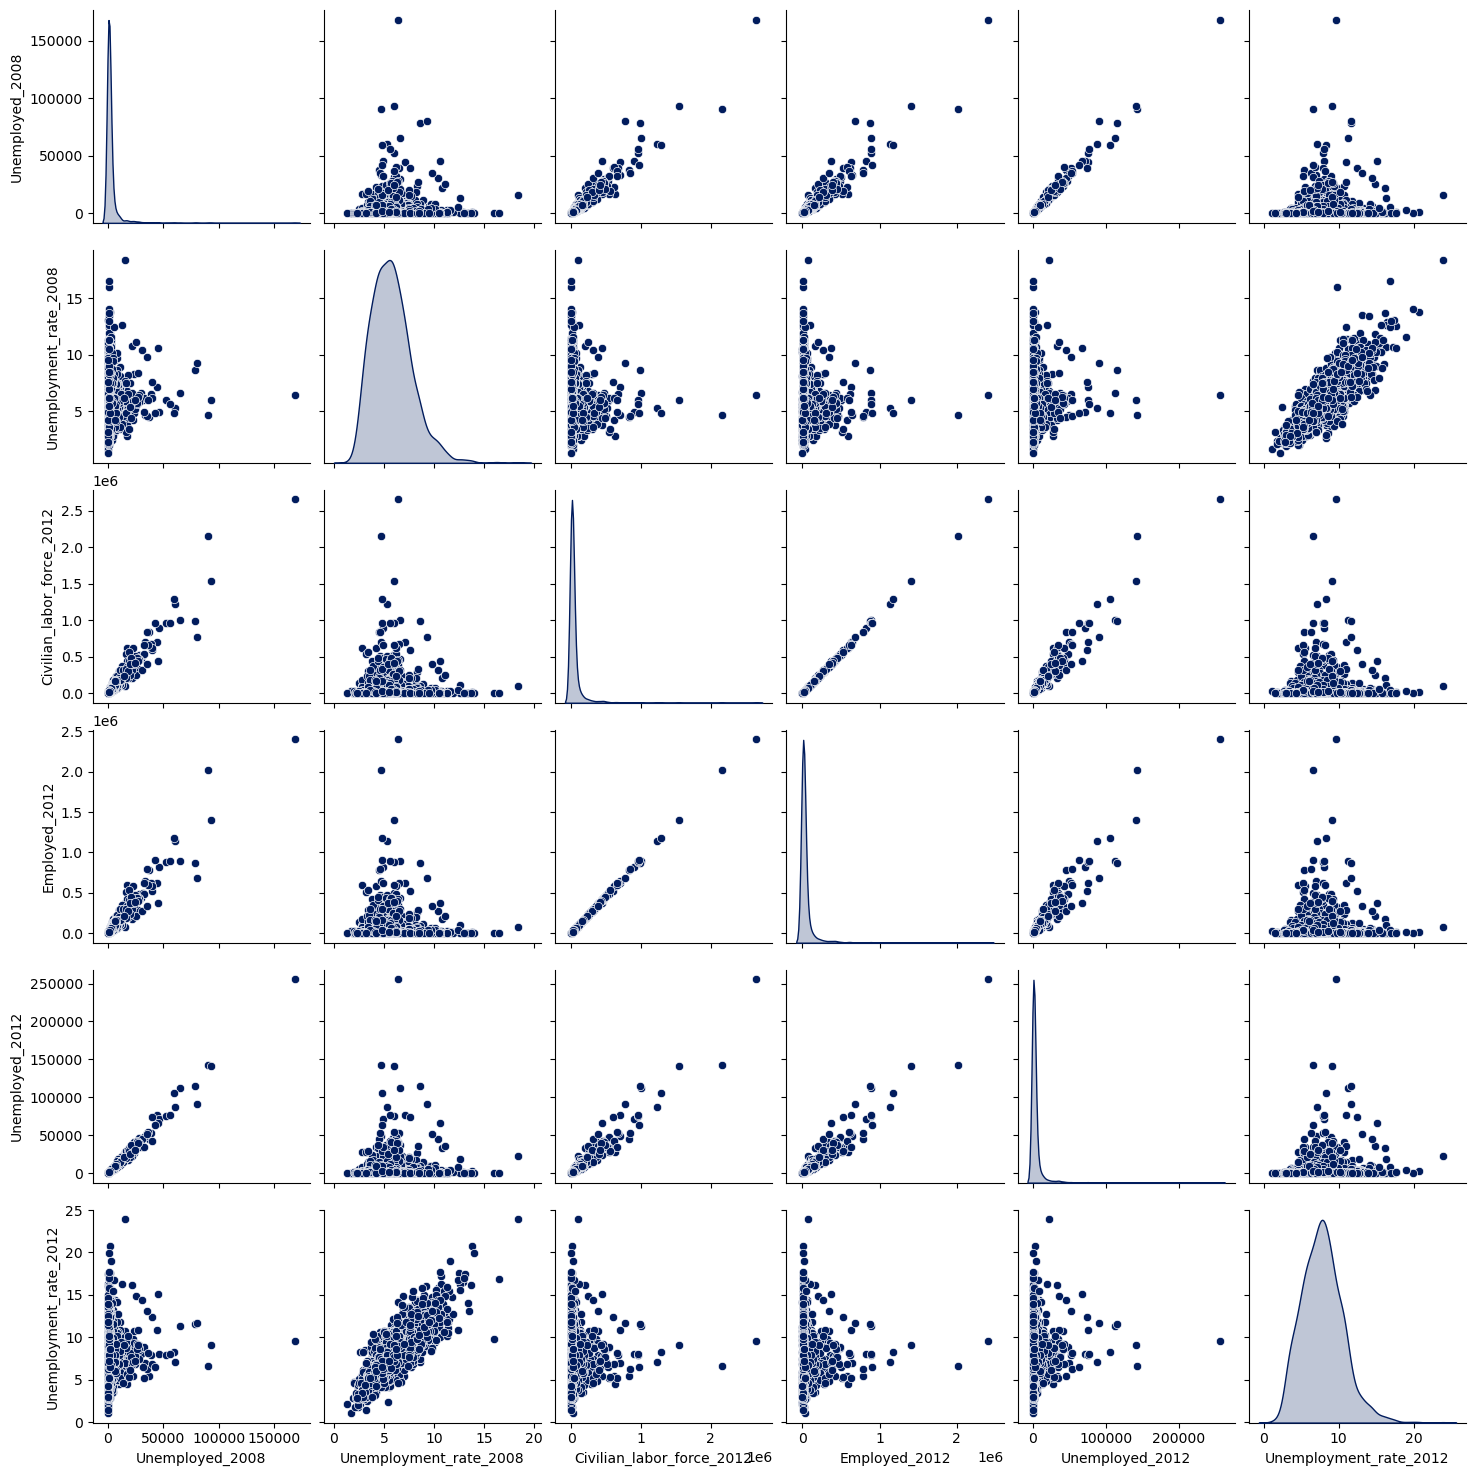

In [382]:
#---------------------------------------------------------------------------------------------------------------
# Partie 2 : L’analyse exploratoire
#---------------------------------------------------------------------------------------------------------------

# Quelques informations sur les bases de donnees df_votes
print("Les informations sur la base df_votes")
print(f"{df_votes.info()}\n")                  
print(f"{df_votes.describe(include='all')}\n")  

# Analyse de la target
print("L'analyse de la target")
print(f"{df_votes['target'].value_counts()}\n")

#---------------------------------------------------------------------------------------------------------------
# Partie 2.1 : Suppression des variables non pertinentes au regard du dictionnaire de donnnes
#---------------------------------------------------------------------------------------------------------------

# Les totaux n'ont pas un grand interet a etre modelise 
# Les codes ne sont pas caracteristiques des donnees socio-demographiques
# Les area name sont presents plusieurs fois dans les donnees 
# Les state sont egalement presents plusieurs fois on en garde une seule
# On supprime les intervalles de confiance de l'estimation des donnees de pauvrete
# On supprime egalement les donnees de naissance, de mortalite, de variation et de migration  
# On garde les variables les plus pertinentes pour l'etude
col_to_delete_1 = [col for col in df_votes.columns if 'total' in col]
col_to_delete_2 = [col for col in df_votes.columns if 'code' in col.lower()]
col_to_delete_3 = [col for col in df_votes.columns if 'area' in col.lower()]
col_to_delete_4 = []
if all(col in df_votes.columns for col in ['State','Stabr']): 
    col_to_delete_4 = ['State','Stabr'] 
    df_votes['state'] = df_votes['State'].iloc[:,0]
col_to_delete_5 = [col for col in df_votes.columns if 'CI90' in col]
col_to_delete_6 = [col for col in df_votes.columns if 'birth' in col.lower() or 'death' in col.lower() or \
                   'CHG' in col or 'MIG' in col or 'GQ' in col or 'INC' in col or 'residual' in col.lower()]
col_to_save = ['state','county','target','Metro_2013','Economic_typology_2015'] + \
              [col for col in df_votes.columns if col[-4:] in ['2008','2012','2016','5-19','2019']]
col_to_delete_7 = [col for col in df_votes.columns if col not in col_to_save]
list_col_to_delete = col_to_delete_1 + col_to_delete_2 + col_to_delete_3 + col_to_delete_4 + \
                     col_to_delete_5 + col_to_delete_6 + col_to_delete_7
df_votes.drop(columns = list_col_to_delete, inplace = True)

#---------------------------------------------------------------------------------------------------------------
# Partie 2.2 : Traitement des doublons 
#---------------------------------------------------------------------------------------------------------------

print(f"La base df_votes contient {df_votes[df_votes.duplicated(keep=False)].shape[0]} vrais doublons")

# Ces deux variables serviront a identifier la presence de doublons
features_analyze_duplicates = ['state','county']

# Creation d'une fonction qui retourne le nom du dataframe passe en parametre
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

# Methode pour identifier les faux doublons
def faux_doublons(df, list_col):
    print(f"\nIdentification des faux doublons de la base {get_df_name(df)}\n")
    # On tri les colonnes pour mieux visualiser nos doublons
    cols_sort = list_col + [c for c in df.columns if c not in list_col] 
    # Affichage des faux doublons
    print(df[df.duplicated(subset = list_col, keep=False)][cols_sort].sort_values(by=list_col[0])[:10])
    # On isole les lignes sur lesquels on souhaite proceder a l'aggregation
    df_dup = df[df.duplicated(subset = list_col, keep=False)].reset_index(drop=True)
    print(f"La base de doublons fait {df_dup.shape[0]} lignes et {df_dup.shape[1]} colonnes")
    # On retire egalement ces lignes du df et grace a ~ qui inverse les True en False du vecteur de boolean et inversement
    df = df[~df.duplicated(subset =list_col, keep=False)].reset_index(drop=True)
    print(f"La base sans doublons fait {df.shape[0]} lignes et {df.shape[1]} colonnes")
    return df, df_dup

# Identification des faux doublons
df_votes, df_votes_duplicated = faux_doublons(df_votes, features_analyze_duplicates)

#---------------------------------------------------------------------------------------------------------------
# Partie 2.3 : Splitter la base de donnees en 2 parties train et test 
#---------------------------------------------------------------------------------------------------------------

# On splitte aleatoirement la base de donnees df_votes en 2 parties
train, test = train_test_split(df_votes, test_size=0.33, random_state=42)

print(f"\nLa base train fait {train.shape[0]} lignes et {train.shape[1]} colonnes")
print(f"La base test fait {test.shape[0]} lignes et {test.shape[1]} colonnes")

#---------------------------------------------------------------------------------------------------------------
# Partie 2.4 : Distribution des variables numeriques et categorielles
#---------------------------------------------------------------------------------------------------------------

# Identifions les colonnes categorielles et les numeriques
col_categoricals = [col for col in train.columns if train[col].dtype=='O']
col_numericals = [col for col in train.columns if col not in col_categoricals]
print(f"\nListe des colonnes catégorielles :\n{col_categoricals}")
print(f"\nListe des colonnes numériques :\n{col_numericals}\n")

col_numericals = col_numericals[:30]

# On determine les couleurs pour les graphiques statistiques
colors = ["#011C5D"]
customPalette = sns.set_palette(sns.color_palette(colors))

# On affiche les distributions
temp=pd.melt(train[col_numericals].reset_index(), id_vars='index', value_vars=col_numericals).iloc[:,-2:]
 
ncols = 3
nrows = len(col_numericals) // ncols + (len(col_numericals) % ncols > 0)

plt.figure(figsize=(17, 14))
plt.subplots_adjust(hspace=1)
plt.suptitle("Distributiondes variables continues\n univariees et bivariees", fontsize=18, y=0.95)

for n, variable in enumerate(col_numericals):
    ax = plt.subplot(nrows, ncols, n + 1)
    sns.kdeplot(ax=ax, data=temp[temp['variable']==variable], legend=None, palette=customPalette, fill=True)
    ax.grid(which='major', axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title(variable, loc= 'center', fontsize=12)
    
del(temp)
sns.pairplot(data = train[col_numericals[-6:]].reset_index(drop=True), diag_kind = 'kde') # ici on a represente les 6 dernières variables numeriques
plt.show()


In [377]:
col_to_delete_5 = [col for col in df_votes.columns if 'Birth' in col or 'Death' in col or 'CHG' in col or 'MIG' in col or 'GQ' in col or 'INC' in col]
print(col_to_delete_5)

['MEDHHINC_2019', 'CI90LBINC_2019', 'CI90UBINC_2019', 'N_POP_CHG_2010', 'N_POP_CHG_2011', 'N_POP_CHG_2012', 'N_POP_CHG_2013', 'N_POP_CHG_2014', 'N_POP_CHG_2015', 'N_POP_CHG_2016', 'N_POP_CHG_2017', 'N_POP_CHG_2018', 'N_POP_CHG_2019', 'Births_2010', 'Births_2011', 'Births_2012', 'Births_2013', 'Births_2014', 'Births_2015', 'Births_2016', 'Births_2017', 'Births_2018', 'Births_2019', 'Deaths_2010', 'Deaths_2011', 'Deaths_2012', 'Deaths_2013', 'Deaths_2014', 'Deaths_2015', 'Deaths_2016', 'Deaths_2017', 'Deaths_2018', 'Deaths_2019', 'NATURAL_INC_2010', 'NATURAL_INC_2011', 'NATURAL_INC_2012', 'NATURAL_INC_2013', 'NATURAL_INC_2014', 'NATURAL_INC_2015', 'NATURAL_INC_2016', 'NATURAL_INC_2017', 'NATURAL_INC_2018', 'NATURAL_INC_2019', 'INTERNATIONAL_MIG_2010', 'INTERNATIONAL_MIG_2011', 'INTERNATIONAL_MIG_2012', 'INTERNATIONAL_MIG_2013', 'INTERNATIONAL_MIG_2014', 'INTERNATIONAL_MIG_2015', 'INTERNATIONAL_MIG_2016', 'INTERNATIONAL_MIG_2017', 'INTERNATIONAL_MIG_2018', 'INTERNATIONAL_MIG_2019', 'DOMES